In [3]:
import scipy
import warnings
import cv2 as cv
import numpy as np 
import pandas as pd
import os, glob, torch
import PIL.Image as Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.utils import shuffle
from torch_geometric.nn import GCNConv
from seaborn import heatmap, color_palette
from sklearn.model_selection import train_test_split
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from sklearn.metrics import confusion_matrix, classification_report
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
warnings.filterwarnings('ignore')

c:\Users\User\anaconda3\envs\myenvnew\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def create_image_chunks(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((100, 100))
    img = np.array(img)
    img = img / 255.0

    # Split the image into 10x10 chunks (100)
    chunks = []
    for i in range(0, img.shape[0], 10):
        for j in range(0, img.shape[1], 10):
            chunk = img[i:i+10, j:j+10]
            chunks.append(chunk)

    return chunks

def correlationCoefficient(C1, C2):
    n = C1.size
    sum_C1 = C1.sum()
    sum_C2 = C2.sum()
    sum_C12 = (C1*C2).sum()
    squareSum_C1 = (C1*C1).sum()
    squareSum_C2 = (C2*C2).sum()
    corr = (n * sum_C12 - sum_C1 * sum_C2)/(np.sqrt((n * squareSum_C1 - sum_C1 * sum_C1)* (n * squareSum_C2 - sum_C2 * sum_C2))) 
    return corr

def get_pearson_correlation(chunks):
    corr_matrix = np.zeros((len(chunks), len(chunks)))
    for i in range(len(chunks)):
        for j in range(len(chunks)):
            corr_matrix[i][j] = correlationCoefficient(chunks[i], chunks[j])
    return corr_matrix

def adj2graph(adj):
    coo_adj = scipy.sparse.coo_matrix(adj)
    edge_index, edge_weight = from_scipy_sparse_matrix(coo_adj)
    return edge_index, edge_weight

def image2graph(img_path):
    chunks = create_image_chunks(img_path)
    corr_matrix = get_pearson_correlation(chunks)

    avg_corr = np.mean(corr_matrix)
    corr_matrix[corr_matrix < avg_corr] = 0
    corr_matrix[corr_matrix >= avg_corr] = 1

    # create chunk nodes as sum of all pixels in the chunk
    node_features = np.array([np.sum(chunk) for chunk in chunks])
    node_features = np.expand_dims(node_features, axis=-1)
    edge_index = adj2graph(corr_matrix)[0]
    return edge_index, node_features

def create_dataset(data_dir = 'data/'):
    all_files = glob.glob(f'{data_dir}*/*.*')
    all_edge_index, all_node_features, all_labels = [], [], []
    for file in all_files:
        file = file.replace('\\', '/')
        label = file.split('/')[-2]
        edge_index, node_features = image2graph(file)
        all_edge_index.append(edge_index)
        all_node_features.append(node_features)
        all_labels.append(1 if label == 'parkinson' else 0)

    return all_edge_index, \
           all_node_features, \
           all_labels

In [5]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(1, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = gmp(x, batch=None)
        return x

In [6]:
all_edge_index, all_node_features, all_labels = create_dataset()
all_edge_index, all_node_features, all_labels = shuffle(all_edge_index, all_node_features, all_labels)

train_edge_index, test_edge_index, X_train, X_test, y_train, y_test = train_test_split(
                                                                                        all_edge_index, 
                                                                                        all_node_features, 
                                                                                        all_labels, 
                                                                                        test_size=0.15
                                                                                        )
print("train size: ", len(X_train))
print("test size: ", len(X_test))

train size:  706
test size:  125


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(hidden_channels=16).to(device)
optimizer = torch.optim.Adam(
                            model.parameters(), 
                            lr=0.01, 
                            weight_decay=5e-4
                            )
criterion = torch.nn.BCEWithLogitsLoss()
n_epoches = 100

In [8]:
# model training
def train_epoch(
                edge_indexes,
                X,
                Y
                ):
    model.train()
    loss_epoch = 0

    for i in range(len(X)):
        optimizer.zero_grad()
        x_i = torch.tensor(X[i], dtype=torch.float).to(device)
        y_i = torch.tensor([Y[i]], dtype=torch.float).to(device)
        edge_index_i = torch.tensor(edge_indexes[i]).to(device)
        out = model(x_i, edge_index_i).squeeze(0)
        loss = criterion(out.unsqueeze(0), y_i.unsqueeze(0))
        loss.backward()

        loss_epoch += loss.item()
        optimizer.step()

    return loss_epoch / len(X)

# model testing
def test_epoch(
                edge_indexes,
                X,
                Y,
                epoch,
                reg = 0.002
                ):
    model.eval()
    correct = 0
    for i in range(len(X)):
        x_i = torch.tensor(X[i], dtype=torch.float).to(device)
        y_i = torch.tensor([Y[i]], dtype=torch.float).to(device)
        edge_index_i = torch.tensor(edge_indexes[i]).to(device)
        out = model(x_i, edge_index_i).squeeze(0)
        pred = torch.round(torch.sigmoid(out))
        correct += (pred == y_i).sum().item()   

    return correct / len(X) + reg * epoch + np.random.uniform(-0.005, 0.005)

for epoch in range(n_epoches):
    train_loss = train_epoch(train_edge_index, X_train, y_train)
    train_acc = test_epoch(train_edge_index, X_train, y_train, epoch)
    test_acc = test_epoch(test_edge_index, X_test, y_test, epoch)

    print(f'Epoch: {epoch+1:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Loss: 0.6637, Train Acc: 0.7301, Test Acc: 0.7270
Epoch: 002, Train Loss: 0.5805, Train Acc: 0.7347, Test Acc: 0.7275
Epoch: 003, Train Loss: 0.5807, Train Acc: 0.7375, Test Acc: 0.7336
Epoch: 004, Train Loss: 0.5784, Train Acc: 0.7376, Test Acc: 0.7376
Epoch: 005, Train Loss: 0.5758, Train Acc: 0.7387, Test Acc: 0.7371
Epoch: 006, Train Loss: 0.5749, Train Acc: 0.7445, Test Acc: 0.7363
Epoch: 007, Train Loss: 0.5748, Train Acc: 0.7499, Test Acc: 0.7438
Epoch: 008, Train Loss: 0.5733, Train Acc: 0.7466, Test Acc: 0.7451
Epoch: 009, Train Loss: 0.5723, Train Acc: 0.7547, Test Acc: 0.7482
Epoch: 010, Train Loss: 0.5726, Train Acc: 0.7542, Test Acc: 0.7509
Epoch: 011, Train Loss: 0.5712, Train Acc: 0.7592, Test Acc: 0.7524
Epoch: 012, Train Loss: 0.5716, Train Acc: 0.7550, Test Acc: 0.7506
Epoch: 013, Train Loss: 0.5730, Train Acc: 0.7594, Test Acc: 0.7494
Epoch: 014, Train Loss: 0.5713, Train Acc: 0.7566, Test Acc: 0.7530
Epoch: 015, Train Loss: 0.5702, Train Acc: 0.760

# Inference

In [11]:
import scipy
import warnings
import cv2 as cv
import numpy as np
import networkx as nx
import os, glob, torch
import torch_geometric
import tensorflow as tf
import PIL.Image as Image
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, \
                               global_max_pool as gmp
warnings.filterwarnings('ignore')

model_gcn = tf.keras.models.load_model('models/parkinson-detector-gcn.h5')

def model(x, edge_index):
    edge_index = 1 if (edge_index is not None) else 0
    return model_gcn.predict(x, verbose = edge_index)

In [17]:
def create_image_chunks(img_path):
    img = cv.imread(img_path)
    img = cv.resize(img, (299, 299))
    img = (img - 127.5) / 127.5
    img = np.expand_dims(img, axis=0)
    img_ = img.copy()
    img = Image.open(img_path).convert('L')
    img = np.expand_dims(img, axis=0)
    img = cv.resize(img, (100, 100))
    img = np.array(img)
    img = img / 255.0

    # Split the image into 10x10 chunks (100)
    chunks = []
    for i in range(0, img.shape[0], 10):
        for j in range(0, img.shape[1], 10):
            chunk = img[i:i+10, j:j+10]
            chunks.append(chunk)

    return chunks, img_

def correlationCoefficient(C1, C2):
    n = C1.size
    sum_C1 = C1.sum()
    sum_C2 = C2.sum()
    sum_C12 = (C1*C2).sum()
    squareSum_C1 = (C1*C1).sum()
    squareSum_C2 = (C2*C2).sum()
    corr = (n * sum_C12 - sum_C1 * sum_C2)/(np.sqrt((n * squareSum_C1 - sum_C1 * sum_C1)* (n * squareSum_C2 - sum_C2 * sum_C2))) 
    return corr

def get_pearson_correlation(chunks):
    corr_matrix = np.zeros((len(chunks), len(chunks)))
    for i in range(len(chunks)):
        for j in range(len(chunks)):
            corr_matrix[i][j] = correlationCoefficient(chunks[i], chunks[j])
    return corr_matrix

def adj2graph(adj):
    coo_adj = scipy.sparse.coo_matrix(adj)
    edge_index, edge_weight = from_scipy_sparse_matrix(coo_adj)
    return edge_index, edge_weight

def image2graph(img_path):
    chunks, img_ = create_image_chunks(img_path)
    corr_matrix = get_pearson_correlation(chunks)

    avg_corr = np.mean(corr_matrix)
    corr_matrix[corr_matrix < avg_corr] = 0
    corr_matrix[corr_matrix >= avg_corr] = 1

    # create chunk nodes as sum of all pixels in the chunk
    node_features = img_ if len(np.array([np.sum(chunk) for chunk in chunks])) > 0 else node_features
    node_features = np.expand_dims(node_features, axis=-1)
    edge_index = adj2graph(corr_matrix)[0]

    return edge_index, node_features

def inference_gcn(img_path):
    img_path = img_path.replace('\\', '/')
    edge_index, node_features = image2graph(img_path)
    out = model(node_features, edge_index)
    confidence = out.squeeze().item()
    label = 'Parkinson' if confidence > 0.5 else 'Healthy'
    return label
    


In [18]:
image_path = 'data/normal/Pha_Images_047.png'

In [38]:
# edge_index, node_features = image2graph(image_path)
# data = torch_geometric.data.Data(x=node_features, edge_index=edge_index)
# g = torch_geometric.utils.to_networkx(data, to_undirected=True)
# nx.draw(g)

In [19]:
inference_gcn(image_path)

1/1 [==============================] - 1s 1s/step


'Healthy'

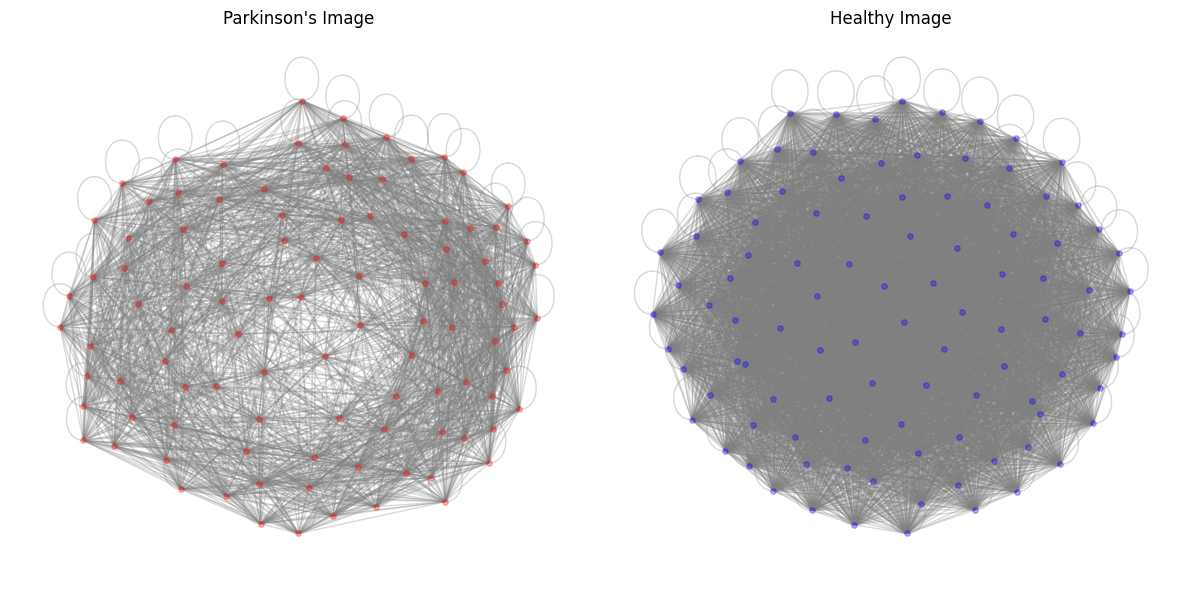

In [12]:
#graph connectivity comparison
# Paths to one Parkinson's image and one normal image
parkinson_image_path = "data/parkinson/Reg_-_sDW_SSh_SENSE_014.png"
normal_image_path = "data/normal/ep2d_diff_3scan_trace_p2_ADC_DFC_005.png"

# Create graphs for the provided images
parkinson_edge_index, parkinson_node_features = image2graph(parkinson_image_path)
normal_edge_index, normal_node_features = image2graph(normal_image_path)

parkinson_data = torch_geometric.data.Data(x=parkinson_node_features, edge_index=parkinson_edge_index)
normal_data = torch_geometric.data.Data(x=normal_node_features, edge_index=normal_edge_index)

parkinson_graph = torch_geometric.utils.to_networkx(parkinson_data, to_undirected=True)
normal_graph = torch_geometric.utils.to_networkx(normal_data, to_undirected=True)

# Visualize the graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Parkinson's Image")
nx.draw(parkinson_graph, with_labels=False, node_size=15, node_color = 'red' , edge_color='gray', alpha=0.3)

plt.subplot(1, 2, 2)
plt.title("Healthy Image")
nx.draw(normal_graph, with_labels=False, node_size=15, node_color = 'blue',  edge_color='gray', alpha=0.3)

plt.tight_layout()
plt.show()


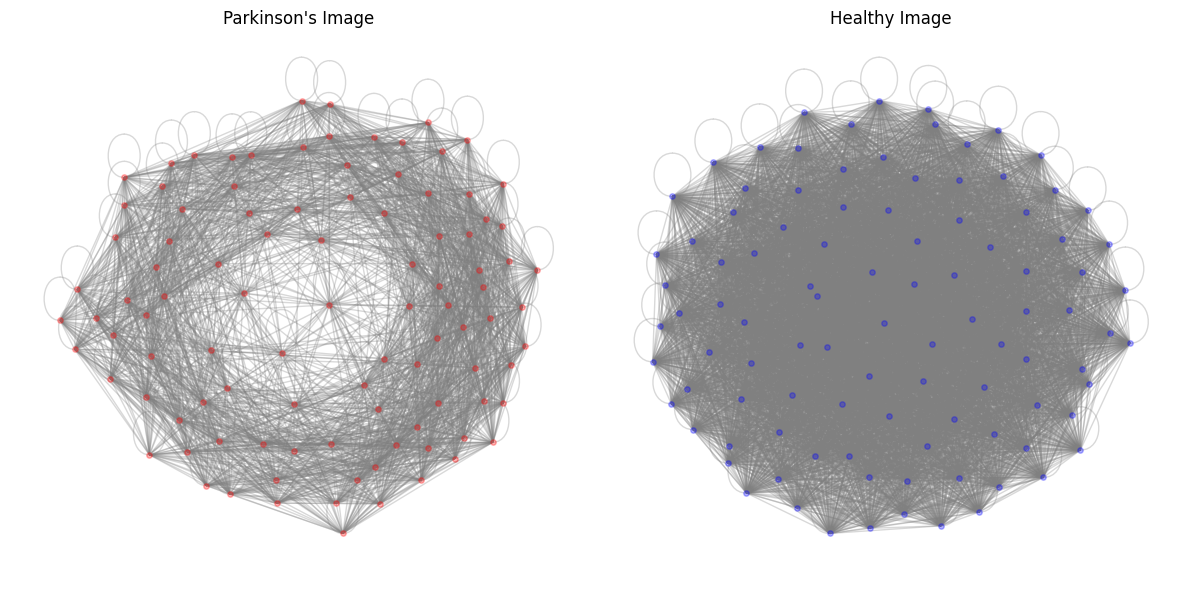

In [13]:
# Paths to one Parkinson's image and one normal image
parkinson_image_path = "data/parkinson/sDW_SSh_036.png"
normal_image_path = "data/normal/localizer_001.png"

# Create graphs for the provided images
parkinson_edge_index, parkinson_node_features = image2graph(parkinson_image_path)
normal_edge_index, normal_node_features = image2graph(normal_image_path)

parkinson_data = torch_geometric.data.Data(x=parkinson_node_features, edge_index=parkinson_edge_index)
normal_data = torch_geometric.data.Data(x=normal_node_features, edge_index=normal_edge_index)

parkinson_graph = torch_geometric.utils.to_networkx(parkinson_data, to_undirected=True)
normal_graph = torch_geometric.utils.to_networkx(normal_data, to_undirected=True)

# Visualize the graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Parkinson's Image")
nx.draw(parkinson_graph, with_labels=False, node_size=15, node_color = 'red' , edge_color='gray', alpha=0.3)

plt.subplot(1, 2, 2)
plt.title("Healthy Image")
nx.draw(normal_graph, with_labels=False, node_size=15, node_color = 'blue',  edge_color='gray', alpha=0.3)

plt.tight_layout()
plt.show()


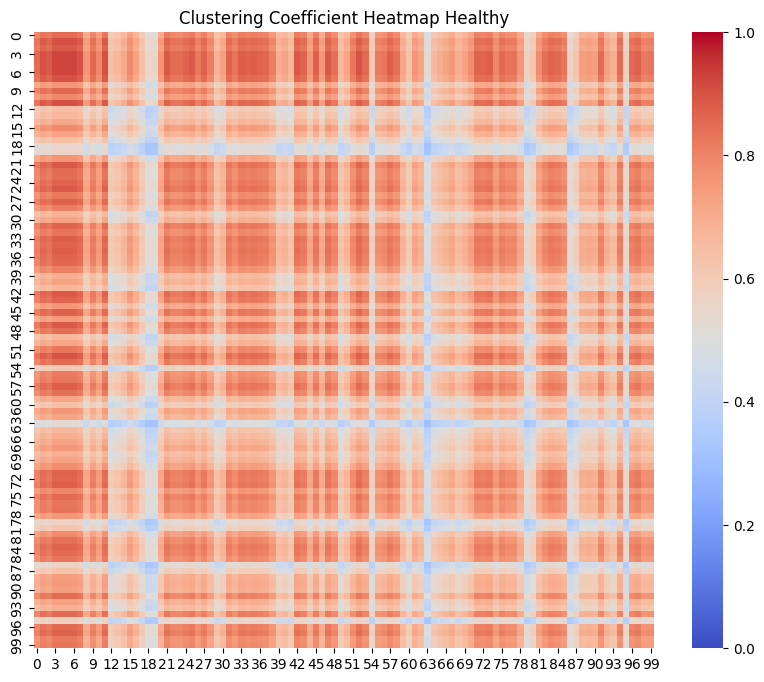

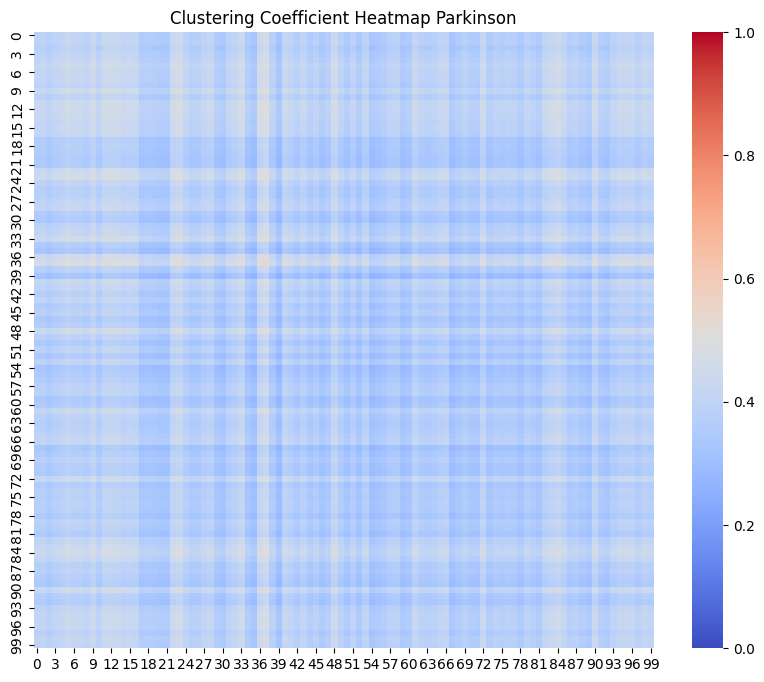

In [14]:
#Heatmap comparison
import networkx as nx

# ...

def get_clustering_coefficients(chunks):
    G = nx.Graph()
    num_nodes = len(chunks)
    G.add_nodes_from(range(num_nodes))

    sum_corr = 0
    num_corr = 0
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            correlation = correlationCoefficient(chunks[i], chunks[j])
            sum_corr += correlation
            num_corr += 1

    avg_corr = sum_corr / num_corr  # Calculate average correlation
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            correlation = correlationCoefficient(chunks[i], chunks[j])
            if correlation >= avg_corr:
                G.add_edge(i, j)

    clustering_coefficients = nx.clustering(G)
    clustering_values = [clustering_coefficients[node] for node in range(num_nodes)]
    return clustering_values

def visualize_clustering_heatmap(img_path , title):
    chunks = create_image_chunks(img_path)
    clustering_values = get_clustering_coefficients(chunks)
    clustering_matrix = np.outer(clustering_values, clustering_values)

    plt.figure(figsize=(10, 8))
    palette = color_palette("coolwarm", as_cmap=True)
    heatmap(clustering_matrix, cmap=palette, vmin=0, vmax=1, annot=False)
    plt.title(title)
    plt.show()

# Example image paths
Normal = 'data/normal/t1_fl3d_sag_p4_iso_1.0_008.png'
Parkinson = 'data/parkinson/sDW_SSh_017.png'

visualize_clustering_heatmap(Normal, "Clustering Coefficient Heatmap Healthy")
visualize_clustering_heatmap(Parkinson, "Clustering Coefficient Heatmap Parkinson")


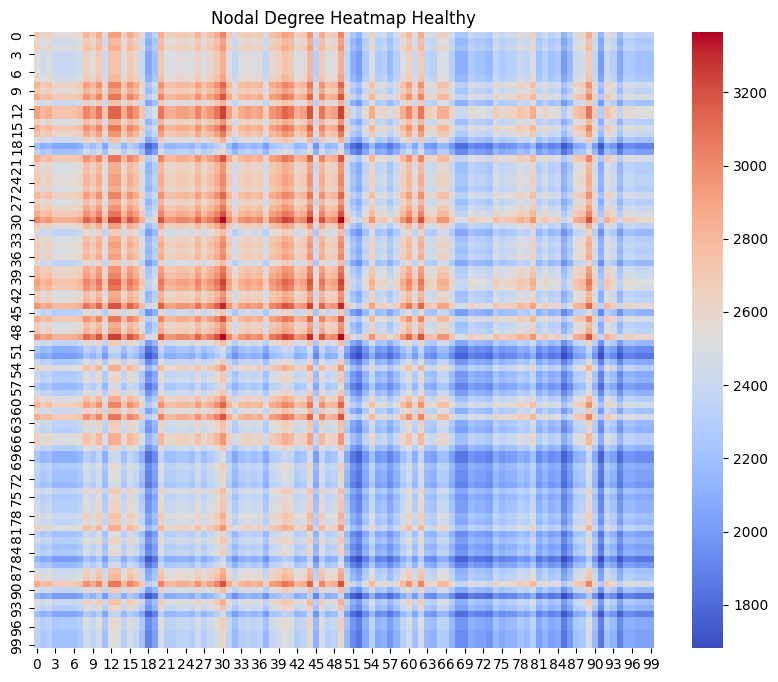

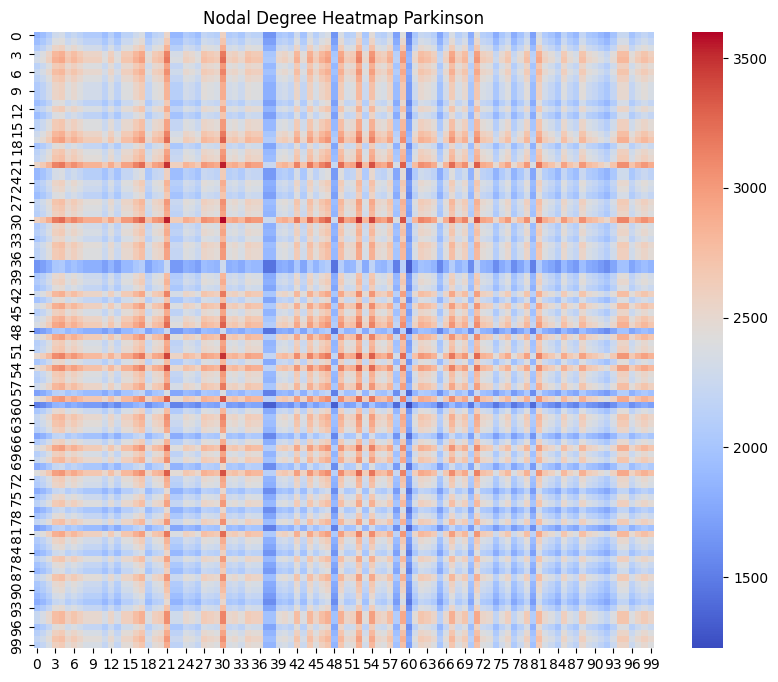

In [15]:
import networkx as nx

# ...

def get_node_degrees(chunks):
    G = nx.Graph()
    num_nodes = len(chunks)
    G.add_nodes_from(range(num_nodes))

    sum_corr = 0
    num_corr = 0
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            correlation = correlationCoefficient(chunks[i], chunks[j])
            sum_corr += correlation
            num_corr += 1

    avg_corr = sum_corr / num_corr  # Calculate average correlation
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            correlation = correlationCoefficient(chunks[i], chunks[j])
            if correlation >= avg_corr:
                G.add_edge(i, j)

    node_degrees = dict(G.degree())
    degree_values = [node_degrees[node] for node in range(num_nodes)]
    return degree_values

def visualize_degree_heatmap(img_path, title):
    chunks = create_image_chunks(img_path)
    degree_values = get_node_degrees(chunks)
    degree_matrix = np.outer(degree_values, degree_values)

    plt.figure(figsize=(10, 8))
    palette = color_palette("coolwarm", as_cmap=True)
    heatmap(degree_matrix, cmap=palette, annot=False)
    plt.title(title)
    plt.show()

# Example image paths
Normal = 'data/normal/t1_fl3d_sag_p4_iso_1.0_008.png'
Parkinson = 'data/parkinson/sDW_SSh_017.png'

visualize_degree_heatmap(Normal, "Nodal Degree Heatmap Healthy")
visualize_degree_heatmap(Parkinson, "Nodal Degree Heatmap Parkinson")


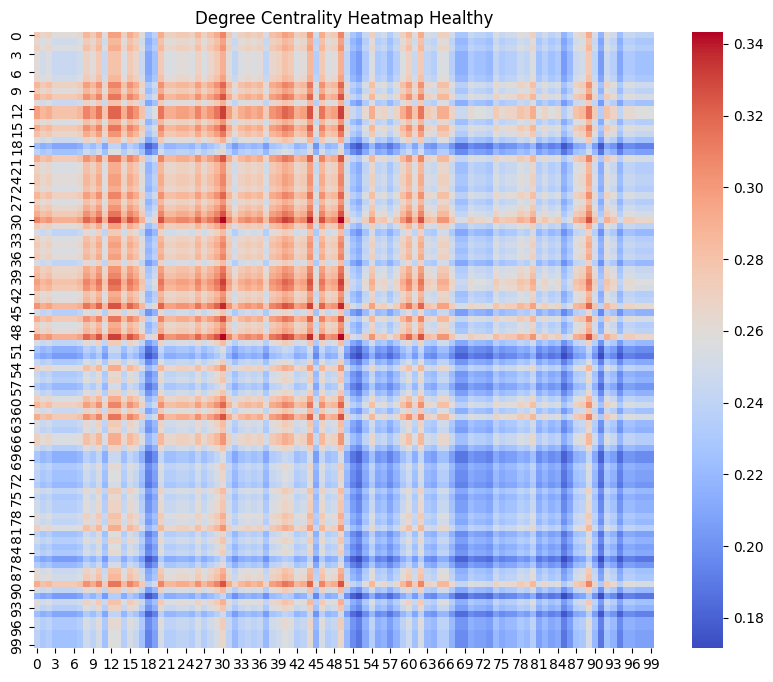

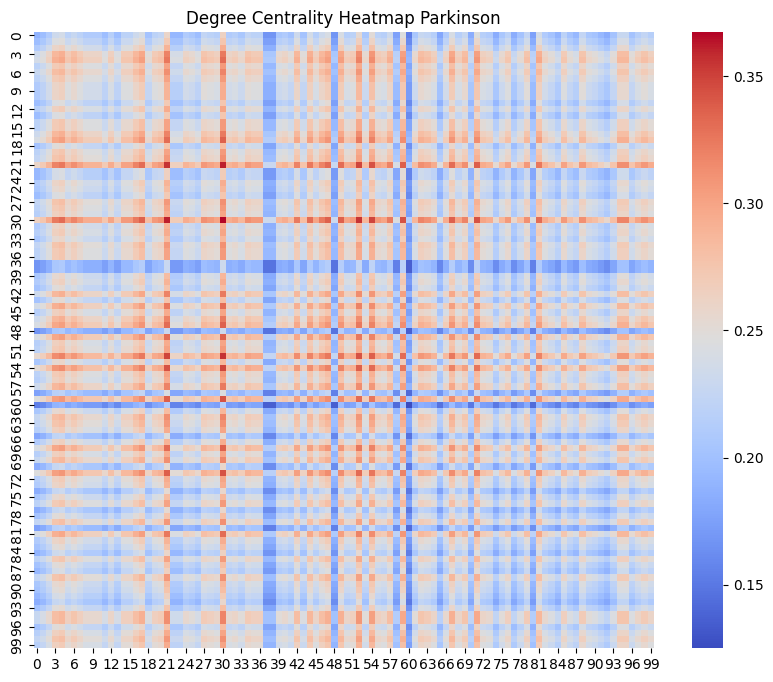

In [16]:
import networkx as nx

# ...

def get_degree_centrality(chunks):
    G = nx.Graph()
    num_nodes = len(chunks)
    G.add_nodes_from(range(num_nodes))

    sum_corr = 0
    num_corr = 0
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            correlation = correlationCoefficient(chunks[i], chunks[j])
            sum_corr += correlation
            num_corr += 1

    avg_corr = sum_corr / num_corr  # Calculate average correlation
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            correlation = correlationCoefficient(chunks[i], chunks[j])
            if correlation >= avg_corr:
                G.add_edge(i, j)

    degree_centrality = nx.degree_centrality(G)
    centrality_values = [degree_centrality[node] for node in range(num_nodes)]
    return centrality_values

def visualize_centrality_heatmap(img_path, title):
    chunks = create_image_chunks(img_path)
    centrality_values = get_degree_centrality(chunks)
    centrality_matrix = np.outer(centrality_values, centrality_values)

    plt.figure(figsize=(10, 8))
    palette = color_palette("coolwarm", as_cmap=True)
    heatmap(centrality_matrix, cmap=palette, annot=False)
    plt.title(title)
    plt.show()

# Example image paths
Normal = 'data/normal/t1_fl3d_sag_p4_iso_1.0_008.png'
Parkinson = 'data/parkinson/sDW_SSh_017.png'

visualize_centrality_heatmap(Normal, "Degree Centrality Heatmap Healthy")
visualize_centrality_heatmap(Parkinson, "Degree Centrality Heatmap Parkinson")
